### Imports

In [1]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# utils
from utils import *


In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)


In [3]:
clf1 = KNeighborsClassifier(leaf_size=49, n_neighbors=25, p=1)
clf2 = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=13,class_weight={0:0.0053, 1: 0.9947})
clf3 = GaussianNB()
clf4 = LogisticRegression(max_iter=1000)
clf5 = LGBMClassifier(lambda_l1 = 2.86e-05,lambda_l2 = 0.754, num_leaves=72, feature_selection = 0.842, bagging_fraction = 0.714, bagging_freq = 2)
clf6 = XGBClassifier( gamma = 0.953, min_child_weight =5, max_depth = 7, eta = 0.2, grow_policy = 'depthwise',n_estimators = 842)
eclf1 = VotingClassifier(estimators=[
        ('knn', clf1), ('dt', clf2), ('gnb', clf3), ('lr', clf4), ('xgb', clf6)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)


### Validation Performance

In [4]:
y_pred = eclf1.predict(X_valid)
get_scores(y_valid, y_pred)

Precision: 0.101
Accuracy: 0.653
Recall: 0.619
F1: 0.174
Fbeta: 0.306
ROC AUC: 0.637
PR AUC: 0.085


<AxesSubplot: title={'center': 'Performance on validation set'}, xlabel='Predictions', ylabel='True Labels'>

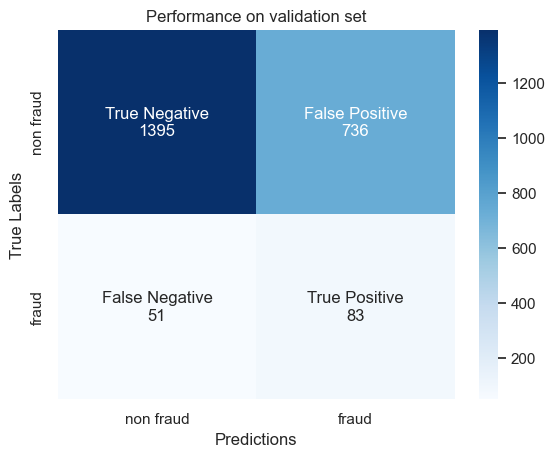

In [5]:
get_confusion_matrix(y_valid, y_pred, "Performance on validation set")

### Test Performance

In [6]:
y_pred = eclf1.predict(X_test)
get_scores(y_valid, y_pred)

Precision: 0.049
Accuracy: 0.642
Recall: 0.276
F1: 0.084
Fbeta: 0.144
ROC AUC: 0.471
PR AUC: 0.056


<AxesSubplot: title={'center': 'Performance on test set'}, xlabel='Predictions', ylabel='True Labels'>

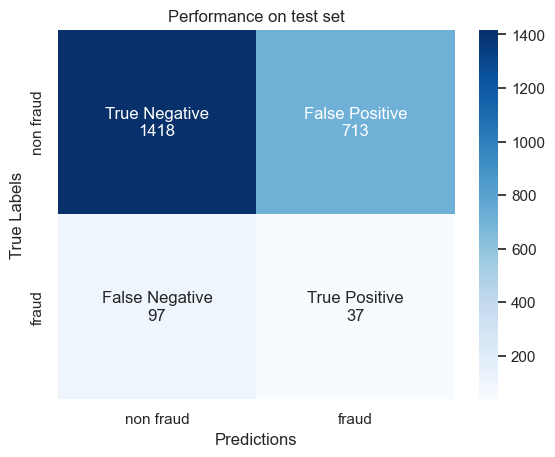

In [7]:
get_confusion_matrix(y_valid, y_pred, "Performance on test set")